<a href="https://colab.research.google.com/github/MironovaSveta/DataScience_test_projects/blob/master/project_animal_shelter/task1/%D0%92%D1%81%D1%82%D1%83%D0%BF%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_DS_%D0%9C%D0%B8%D1%80%D0%BE%D0%BD%D0%BE%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вступительное задание Мироновой Светланы в школу IT направления Data Science

## Формулировка задания и структура отчета

Вступительное задание выполнено Мироновой Светланой 17.10.2022. 

Цель задания: определить, какие факторы влияют на забор животных из приюта города Остин, и научиться предсказывать вероятность забора животного.

Для достижения поставленной цели были решены следующие задачи:

1.   Загрузить данные о животных, прибывающих в приют и отбывающих из приюта города Остин (Техас, США) [Austin Animal Center Shelter Outcomes](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238), [Austin Animal Center Shelter Intakes](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm)
2.   Провести предварительную обработку данных
3.   Провести исследование данных
4.   Построить две модели, предсказывающие, заберут ли животное из приюта
5.   Сравнить модели между собой
6.   Сформулировать выводы




## 1. Сбор данных

In [ ]:
import pandas as pd
from google.colab import files
import os
import io
import matplotlib.pyplot as plt
import pylab
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

Загружаем данные о животных из csv файлов в два датасета: df_intakes (информация о прибывающих в приют животных) и df_outcomes (информация о выходящих из приюта животных)

In [ ]:
uploaded = files.upload()

Saving Austin_Animal_Center_Intakes.csv to Austin_Animal_Center_Intakes.csv
Saving Austin_Animal_Center_Outcomes.csv to Austin_Animal_Center_Outcomes.csv


In [ ]:
df_intakes = pd.read_csv(io.BytesIO(uploaded['Austin_Animal_Center_Intakes.csv']))
df_outcomes = pd.read_csv(io.BytesIO(uploaded['Austin_Animal_Center_Outcomes.csv']))

Объединяем датасеты df_intakes и df_oucomes в датасет df. В датасете df находится информация только о тех животных, для которых есть данные по прибытии в приют (= left join датасетов). 

In [ ]:
df = pd.merge(df_intakes, df_outcomes, on=['Animal ID'], how = "left")

Проверяем правильность построения датасета df: количество и названия столбцов, количество пустых элементов.

In [ ]:
print(df.shape, df_intakes.shape, df_outcomes.shape)

(187041, 23) (144846, 12) (145040, 12)


In [ ]:
df.columns

Index(['Animal ID', 'Name_x', 'DateTime_x', 'MonthYear_x', 'Found Location',
       'Intake Type', 'Intake Condition', 'Animal Type_x', 'Sex upon Intake',
       'Age upon Intake', 'Breed_x', 'Color_x', 'Name_y', 'DateTime_y',
       'MonthYear_y', 'Date of Birth', 'Outcome Type', 'Outcome Subtype',
       'Animal Type_y', 'Sex upon Outcome', 'Age upon Outcome', 'Breed_y',
       'Color_y'],
      dtype='object')

In [ ]:
pd.isnull(df).sum()

Animal ID                0
Name_x               43172
DateTime_x               0
MonthYear_x              0
Found Location           0
Intake Type              0
Intake Condition         0
Animal Type_x            0
Sex upon Intake          1
Age upon Intake          0
Breed_x                  0
Color_x                  0
Name_y               43694
DateTime_y             635
MonthYear_y            635
Date of Birth          635
Outcome Type           670
Outcome Subtype     114064
Animal Type_y          635
Sex upon Outcome       636
Age upon Outcome       675
Breed_y                635
Color_y                635
dtype: int64

## 2. Предварительная обработка данных

Для дальнейшего анализа была выполнена предварительная обработка данных:

*  Исключены 670 строк с `Outcome Type` = None. То есть остались данные только о тех животных, про которых известно, каким именно образом они покинули приют.
*  Обнаружено только одно животное, пол которого неизвестен. Исключим его, то есть строку с `Sex upon Intake` = None из дальнейшего анализа.
*  Обнаружено 40 животных, возраст которых на момент отбытия из приюта неизвестен (столбец `Age upon Outcome`). Поскольку (по сравнению с общим количеством животных) было обнаружено мало животных с неопределенным возрастом, исключим их из дальнейшего анализа.
*  Добавлены колонки `Days_upon_Intake` и `Days_upon_Outcome`, отображающие возраст животного в днях на момент прибытия в приют и отбытия из приюта. Колонки содержат информацию, преобразованную из колонок`Age upon Intake` и `Age upon Outcome`. Отрицательный возраст превращен в положительный.
*  Добавлены колонки `DateTime_Intake` и `DateTime_Outcome`, содержащие информацию о датах, когда животное отправили в приют и выселили из приюта. Колонки хранят информацию из колонок `DateTime_x` и `DateTime_y`, преобразованную из строкового формата в формат datetime.


In [ ]:
df = df[~df['Outcome Type'].isnull()]

In [ ]:
df = df[~df['Sex upon Intake'].isnull()]

In [ ]:
df = df[~df['Age upon Outcome'].isnull()]

In [ ]:
def convertAgeToDays(strAge):
  interval = {"years": 365, "year": 365, "months": 30, "month": 30, "weeks": 7, "week": 7, "days": 1, "day": 1}
  intAge = [abs(int(i.split()[0])) * interval[i.split()[1]] for i in strAge]
  return intAge

In [ ]:
df["Days_upon_Intake"] = convertAgeToDays(df['Age upon Intake'])
df["Days_upon_Outcome"] = convertAgeToDays(df['Age upon Outcome'])

In [ ]:
df["DateTime_Intake"] = pd.to_datetime(df["DateTime_x"], format='%m/%d/%Y %H:%M:%S %p')
df["DateTime_Outcome"] = pd.to_datetime(df["DateTime_y"], format='%m/%d/%Y %H:%M:%S %p')

In [ ]:
pd.isnull(df).sum()

Animal ID                 0
Name_x                43017
DateTime_x                0
MonthYear_x               0
Found Location            0
Intake Type               0
Intake Condition          0
Animal Type_x             0
Sex upon Intake           0
Age upon Intake           0
Breed_x                   0
Color_x                   0
Name_y                43017
DateTime_y                0
MonthYear_y               0
Date of Birth             0
Outcome Type              0
Outcome Subtype      113390
Animal Type_y             0
Sex upon Outcome          0
Age upon Outcome          0
Breed_y                   0
Color_y                   0
Days_upon_Intake          0
Days_upon_Outcome         0
DateTime_Intake           0
DateTime_Outcome          0
dtype: int64

## 3. Исследование данных

### 3a. Меняют ли животные имя в приюте?

Согласно этой проверке, ни одно животное не меняло имя в процессе нахождения в приюте:

In [ ]:
sum(df[~df['Name_x'].isnull()]['Name_x'] == df[~df['Name_x'].isnull()]['Name_y'])

143313

In [ ]:
sum(df[~df['Name_x'].isnull()]['Name_x'] != df[~df['Name_x'].isnull()]['Name_y'])

0

### 3b. В каком состоянии чаще всего принимают животных, в каком возрасте?

В базе данных состояние животных `Intake Condition` описывается одним из 17 типов: обычный (164070 животных), раненый (9389 животных), больной (6757 животных) и так далее. 

In [ ]:
df['Intake Condition'].value_counts()

Normal        164070
Injured         9389
Sick            6757
Nursing         4075
Aged             570
Neonatal         513
Other            348
Medical          242
Feral            140
Pregnant         128
Behavior          86
Space              4
Med Attn           3
Med Urgent         2
Agonal             1
Panleuk            1
Neurologic         1
Name: Intake Condition, dtype: int64

Посмотрим, в каком состоянии и в каком возрасте чаще всего принимают кошек. Для этого разделим кошек по возрастам прибытия в приют `Days_upon_Intake` на шесть категорий согласно https://www.sb.by/articles/vzroslye-ne-po-godam.html.

Исследование показало, что чаще всего в приют поступают здоровые котята, здоровые юниоры и здоровые молодые кошки.

In [ ]:
bins=[0, 0.5 * 365, 2 * 365, 6 * 365, 10 * 365, 20 * 365]
group=['kitten','junior','young_adult','adult', 'senior_adult']
df.loc[df['Animal Type_x'] == 'Cat', ['age_category']]=pd.cut(df["Days_upon_Intake"], bins, labels=group)

df.loc[df['Animal Type_x'] == 'Cat', ['age_category', 'Intake Condition']].value_counts()[:10]

age_category  Intake Condition
kitten        Normal              30597
junior        Normal              12624
young_adult   Normal               4208
kitten        Nursing              2266
adult         Normal               2035
kitten        Sick                 1458
junior        Injured              1324
kitten        Injured              1289
senior_adult  Normal               1092
young_adult   Injured               652
dtype: int64

Посмотрим, в каком состоянии и в каком возрасте чаще всего принимают собак. Для этого разделим собак по возрастам прибытия в приют Days_upon_Intake на четыре категории согласно https://purina.by/node/4880.

Исследование показало, что чаще всего в приют поступают здоровые щенки, здоровые юниоры и здоровые взрослые собаки.


In [ ]:
bins=[0, 1 * 365, 3 * 365, 7 * 365, 20 * 365]
group=['puppy', 'junior', 'adult', 'senior_adult']
df.loc[df['Animal Type_x'] == 'Dog', ['age_category']]=pd.cut(df["Days_upon_Intake"], bins, labels=group)

df.loc[df['Animal Type_x'] == 'Dog', ['age_category', 'Intake Condition']].value_counts()[:10]

age_category  Intake Condition
puppy         Normal              50381
junior        Normal              31413
adult         Normal              17808
senior_adult  Normal               8027
puppy         Injured              1667
junior        Injured              1478
puppy         Sick                 1387
              Nursing               999
adult         Injured               864
senior_adult  Injured               583
dtype: int64

Узнаем, в каком возрасте принимают в приют птиц, домашний скот и остальные категории животных. 

Оказалось, что в приют поступают в основном здоровые животные в возрасте 1 года и меньше, а также заболевшие животные в возрасте меньше 1 года.

In [ ]:
bins=[0, 1 * 365, 2 * 365, 3 * 365, 4 * 365, 5 * 365, 100 * 365]
group=['< 1 year', '1 year', '2 years', '3 years', '4 years', '> 4 years']
df.loc[(df['Animal Type_x'] != 'Dog') & (df['Animal Type_x'] != 'Cat'), ['age_category']]=pd.cut(df["Days_upon_Intake"], bins, labels=group)

df.loc[(df['Animal Type_x'] != 'Dog') & (df['Animal Type_x'] != 'Cat'), ['age_category', 'Intake Condition']].value_counts()[:10]

age_category  Intake Condition
< 1 year      Normal              3801
1 year        Normal              1195
< 1 year      Sick                 916
              Injured              682
1 year        Sick                 621
              Injured              422
2 years       Normal               249
< 1 year      Nursing               94
2 years       Sick                  61
3 years       Normal                60
dtype: int64

### 3c. Как животных чаще принимают?

Рассмотрим pie chart, показывающий, какими способами животное попадает в приют. Больше половины животных заблудились, около четверти животных были принесены их предыдущими владельцами.

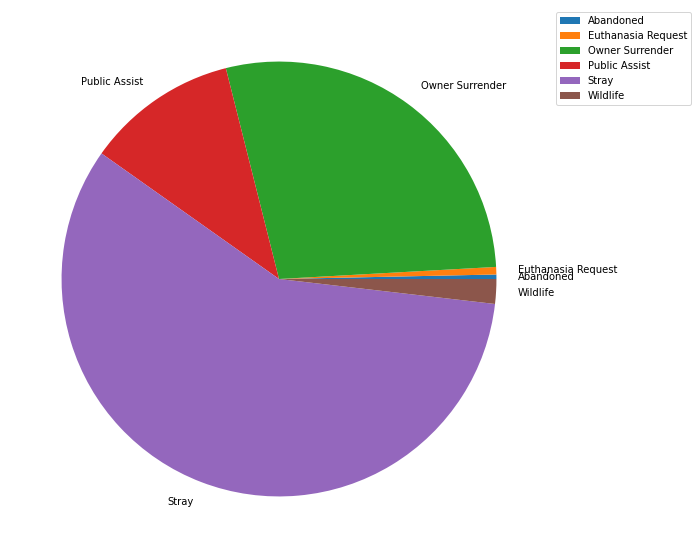

In [ ]:
df.groupby(['Intake Type']).sum().plot.pie(y='Days_upon_Intake', figsize=(10, 10))
pylab.ylabel('')
pylab.legend(bbox_to_anchor=(1,1))
pylab.show()

### 3d. Повлияла ли пандемия на количество животных, покидающих приют?

Посмотрим, повлияла ли пандемия на количество животных в приюте. Для ответа на поставленный вопрос построим график, показывающий, сколько животных приходили или покидали приют за период с 2014 по 2022 годы.

Из анализа графика видно, что ежегодное количество пришедших в приют животных (Intake) примерно равно количеству ушедших из приюта животных (Outcome). При этом видно, что в годы пандемии: 2020, 2021 и 2022 годы, животных попадало в приют приблизительно в два раза меньше, чем в допандемийные годы.

Таким образом, в годы пандемии стали забирать меньше животных из приюта. По-видимому, это обусловлено тем, что в пандемию стали меньше отдавать животных в приюты.

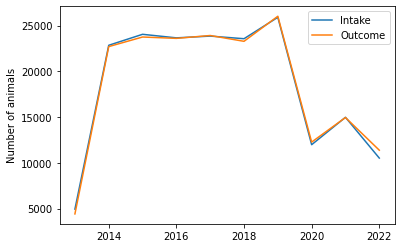

In [ ]:
#df["Outcome Type"].groupby([df["DateTime_Outcome"].dt.year, df["DateTime_Outcome"].dt.month]).count().plot(kind="bar")
plt.plot(df['Intake Type'].groupby(df["DateTime_Intake"].dt.year).count(), '-', label='Intake')
plt.plot(df['Outcome Type'].groupby(df["DateTime_Outcome"].dt.year).count(), '-', label='Outcome')
#plt.plot(df['Outcome Type'].loc[(df['Outcome Type'] == 'Euthanasia')].groupby(df["DateTime_Outcome"].dt.year).count(), '-', label='Euthanasia')
plt.legend(loc='best')
plt.ylabel('Number of animals')
plt.show()

### 3e. Кто чаще покидает приют: кошки или собаки?

Согласно построенному графику, чаще всего приют покидают собаки.

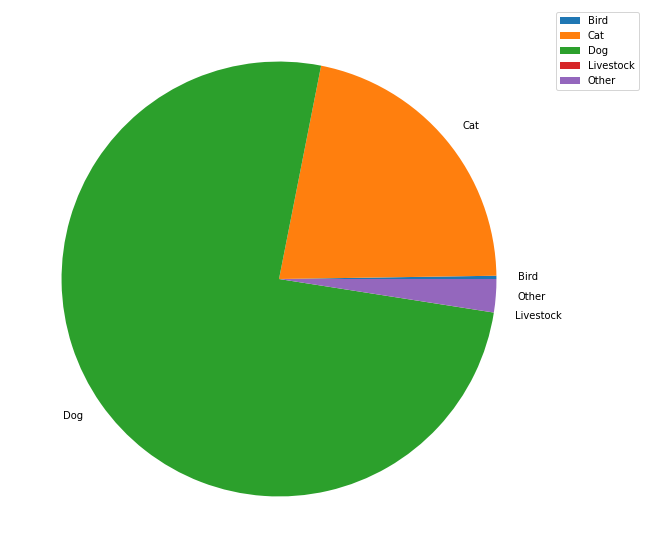

In [ ]:
df.groupby(['Animal Type_x']).sum().plot.pie(y='Days_upon_Outcome', figsize=(10, 10))
pylab.ylabel('')
pylab.legend(bbox_to_anchor=(1,1))
pylab.show()


### 3f. Какими способами разные животные уходят из приюта?

Согласно построенным графикам, больше всего кошек и собак покидают приют, попадая к новым владельцам. На втором месте у кошек трансфер, у собак возврат к прежним владельцам. На третьем месте у кошек возврат к прежним владельцам, у собак трансфер.

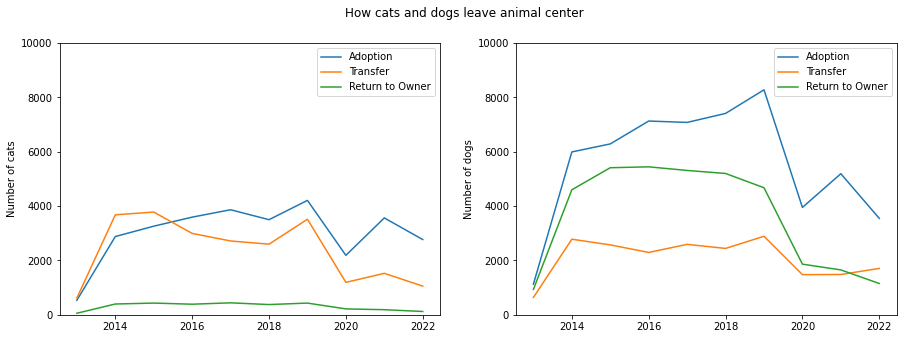

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('How cats and dogs leave animal center')

ax1.plot(df['Outcome Type'].loc[(df['Outcome Type'] == 'Adoption') & (df['Animal Type_x'] == 'Cat')].groupby(df["DateTime_Outcome"].dt.year).count(), '-', label='Adoption')
ax1.plot(df['Outcome Type'].loc[(df['Outcome Type'] == 'Transfer') & (df['Animal Type_x'] == 'Cat')].groupby(df["DateTime_Outcome"].dt.year).count(), '-', label='Transfer')
ax1.plot(df['Outcome Type'].loc[(df['Outcome Type'] == 'Return to Owner') & (df['Animal Type_x'] == 'Cat')].groupby(df["DateTime_Outcome"].dt.year).count(), '-', label='Return to Owner')
ax1.legend(loc='best')
ax1.set(ylabel='Number of cats')
ax1.set_ylim([0, 10000])

ax2.plot(df['Outcome Type'].loc[(df['Outcome Type'] == 'Adoption') & (df['Animal Type_x'] == 'Dog')].groupby(df["DateTime_Outcome"].dt.year).count(), '-', label='Adoption')
ax2.plot(df['Outcome Type'].loc[(df['Outcome Type'] == 'Transfer') & (df['Animal Type_x'] == 'Dog')].groupby(df["DateTime_Outcome"].dt.year).count(), '-', label='Transfer')
ax2.plot(df['Outcome Type'].loc[(df['Outcome Type'] == 'Return to Owner') & (df['Animal Type_x'] == 'Dog')].groupby(df["DateTime_Outcome"].dt.year).count(), '-', label='Return to Owner')
ax2.legend(loc='best')
ax2.set(ylabel='Number of dogs')
ax2.set_ylim([0, 10000])
plt.show()

## 4. Построение моделей

### 4a. Удаление столбцов, не нужных для построения модели

Удаляем столбцы с данными, которые не пригодятся при построении моделей. Оставим следующие столбцы: 'Intake Type', 'Intake Condition', 'Animal Type_x', 'Sex upon Intake', 'age_category', 'Breed_x', 'Color_x', 'Outcome Type', 'Sex upon Outcome'. Целевая переменная 'Outcome Type'.

In [ ]:
df = df.drop(['Animal ID', 'Name_x', 'DateTime_x', 'MonthYear_x', 'Found Location',
       'Age upon Intake', 'Name_y', 'DateTime_y', 'Breed_x', 'Color_x',
       'MonthYear_y', 'Date of Birth', 'Outcome Subtype',
       'Animal Type_y', 'Age upon Outcome', 'Breed_y',
       'Color_y', 'Days_upon_Intake', 'Days_upon_Outcome', 'DateTime_Intake',
       'DateTime_Outcome'],axis = 1)

In [ ]:
df.columns

Index(['Intake Type', 'Intake Condition', 'Animal Type_x', 'Sex upon Intake',
       'Outcome Type', 'Sex upon Outcome', 'age_category'],
      dtype='object')

### 4b. Преобразование категориальных столбцов в числовые

Создаем столбцы с числовыми данными на основе категориальных данных. Категории, в которых мало значений, объединяем в категорию "Other_<...>"

In [ ]:
df_intake_type = pd.get_dummies(df['Intake Type'])
print(df_intake_type.value_counts())

Abandoned  Euthanasia Request  Owner Surrender  Public Assist  Stray  Wildlife
0          0                   0                0              1      0           121476
                               1                0              0      0            44182
                               0                1              0      0            13877
                                                0              0      1             5533
1          0                   0                0              0      0              978
0          1                   0                0              0      0              284
dtype: int64


In [ ]:
df_intake_condition = pd.get_dummies(df['Intake Condition'])

columns_to_concat = ['Agonal', 'Panleuk', 'Neurologic', 'Med Urgent',\
                     'Med Attn', 'Space', 'Behavior', 'Pregnant', 'Feral',\
                     'Medical']
for col in columns_to_concat:
  df_intake_condition['Other'] = df_intake_condition['Other'] + df_intake_condition[col]

df_intake_condition = df_intake_condition.drop(columns_to_concat, axis = 1)
df_intake_condition['Other_Intake_condition'] = df_intake_condition['Other']
df_intake_condition = df_intake_condition.drop("Other", axis = 1)

print(df_intake_condition.value_counts())

Aged  Injured  Neonatal  Normal  Nursing  Sick  Other_Intake_condition
0     0        0         1       0        0     0                         164070
      1        0         0       0        0     0                           9389
      0        0         0       0        1     0                           6757
                                 1        0     0                           4075
                                 0        0     1                            956
1     0        0         0       0        0     0                            570
0     0        1         0       0        0     0                            513
dtype: int64


In [ ]:
df_animal_type = pd.get_dummies(df['Animal Type_x'])

df_animal_type['Other_Animal_type'] = df_animal_type['Other']
df_animal_type = df_animal_type.drop("Other", axis = 1)

print(df_animal_type.value_counts())

Bird  Cat  Dog  Livestock  Other_Animal_type
0     0    1    0          0                    117375
      1    0    0          0                     60550
      0    0    0          1                      7691
1     0    0    0          0                       689
0     0    0    1          0                        25
dtype: int64


In [ ]:
df_sex_intake = pd.get_dummies(df['Sex upon Intake'])
df_sex_intake.rename(columns={'Intact Female': 'Intake_IF', 'Intact Male': 'Intake_IM',\
                              'Neutered Male': 'Intake_NM', 'Spayed Female': 'Intake_SF',\
                              'Unknown': "Intake_FM"}, inplace=True)

print(df_sex_intake.value_counts())

Intake_IF  Intake_IM  Intake_NM  Intake_SF  Intake_FM
0          1          0          0          0            55768
1          0          0          0          0            51292
0          0          1          0          0            37898
                      0          1          0            29997
                                 0          1            11375
dtype: int64


In [ ]:
df_sex_outcome = pd.get_dummies(df['Sex upon Outcome'])
df_sex_outcome.rename(columns={'Intact Female': 'Outcome_IF', 'Intact Male': 'Outcome_IM',\
                              'Neutered Male': 'Outcome_NM', 'Spayed Female': 'Outcome_SF',\
                              'Unknown': "Outcome_FM"}, inplace=True)

print(df_sex_outcome.value_counts())

Outcome_IF  Outcome_IM  Outcome_NM  Outcome_SF  Outcome_FM
0           0           1           0           0             72472
                        0           1           0             61555
            1           0           0           0             21194
1           0           0           0           0             19734
0           0           0           0           1             11375
dtype: int64


In [ ]:
df['age_category'].replace({"puppy": 0, "kitten": 0, "< 1 year": 0, "1 year": 1,\
                            "junior": 1, "young_adult": 2, "2 years": 2, \
                            "adult": 3, "3 years": 3, "senior_adult": 4, \
                            "> 4 years": 4, "4 years": 4}, inplace=True)

print(df["age_category"].value_counts())

0.0    96348
1.0    50588
3.0    21739
4.0    11057
2.0     5600
Name: age_category, dtype: int64


In [ ]:
df = df.drop(['Intake Type', 'Intake Condition', 'Animal Type_x', 'Sex upon Intake', \
              'Sex upon Outcome'],axis = 1)

In [ ]:
df = pd.concat([df, df_intake_type], axis=1)
df = pd.concat([df, df_intake_condition], axis=1)
df = pd.concat([df, df_animal_type], axis=1)
df = pd.concat([df, df_sex_intake], axis=1)
df = pd.concat([df, df_sex_outcome], axis=1)

Оставляем только те строки, в которых есть данные и про приход, и про отбытие животного

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.columns

Index(['Outcome Type', 'age_category', 'Abandoned', 'Euthanasia Request',
       'Owner Surrender', 'Public Assist', 'Stray', 'Wildlife', 'Aged',
       'Injured', 'Neonatal', 'Normal', 'Nursing', 'Sick',
       'Other_Intake_condition', 'Bird', 'Cat', 'Dog', 'Livestock',
       'Other_Animal_type', 'Intake_IF', 'Intake_IM', 'Intake_NM', 'Intake_SF',
       'Intake_FM', 'Outcome_IF', 'Outcome_IM', 'Outcome_NM', 'Outcome_SF',
       'Outcome_FM'],
      dtype='object')

Изобразим корреляцию между получившимися параметрами. Красными квадратами обозначены пары параметров, коррелирующие друг с другом. Например, найденные в дикой природе животные (категория `Wildlife`) обычно принадлежат к категории `Other animal type`, и их пол обычно не определен.

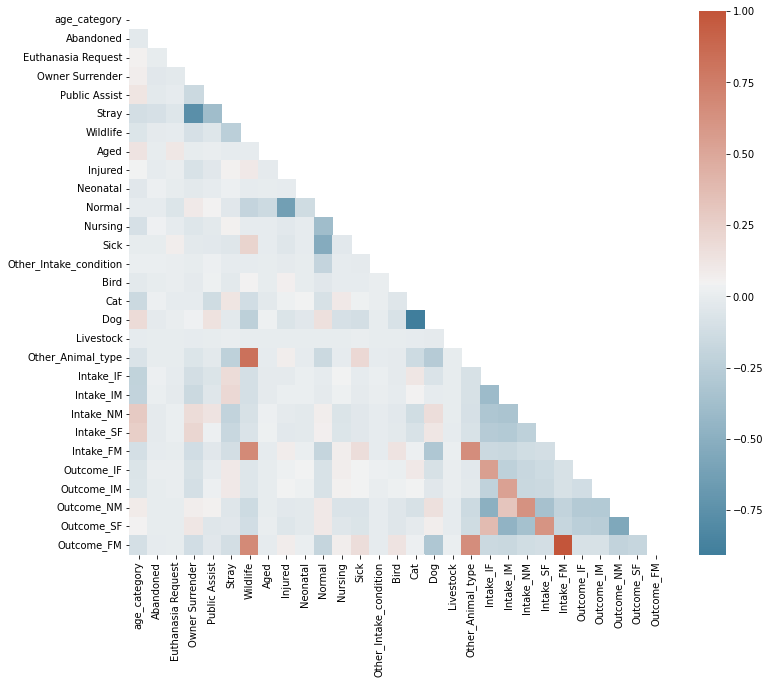

In [ ]:
# Correlation between different variables
#
corr = df.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap)

### 4c. Формирование признаков и целевой переменной

Формируем признаки `X` и целевую переменную `y`

In [ ]:
X, y = df.drop(columns=["Outcome Type"]), df["Outcome Type"]

In [ ]:
X.head()

,age_category,Abandoned,Euthanasia Request,Owner Surrender,Public Assist,Stray,Wildlife,Aged,Injured,Neonatal,...,Intake_IF,Intake_IM,Intake_NM,Intake_SF,Intake_FM,Outcome_IF,Outcome_IM,Outcome_NM,Outcome_SF,Outcome_FM
0,0.0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0.0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,4.0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,1.0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
y.head()

0           Transfer
1           Adoption
2           Adoption
3    Return to Owner
4           Adoption
Name: Outcome Type, dtype: object

Разделяем данные на выборки для обучения и проверки

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.2)
y_train, y_test = train_test_split(y, test_size=0.2)

In [ ]:
X_train.columns

Index(['age_category', 'Abandoned', 'Euthanasia Request', 'Owner Surrender',
       'Public Assist', 'Stray', 'Wildlife', 'Aged', 'Injured', 'Neonatal',
       'Normal', 'Nursing', 'Sick', 'Other_Intake_condition', 'Bird', 'Cat',
       'Dog', 'Livestock', 'Other_Animal_type', 'Intake_IF', 'Intake_IM',
       'Intake_NM', 'Intake_SF', 'Intake_FM', 'Outcome_IF', 'Outcome_IM',
       'Outcome_NM', 'Outcome_SF', 'Outcome_FM'],
      dtype='object')

### 4d. Построение модели логистической регрессии

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train,y_train)
LR_train   = model.predict(X_train)
LR_test    = model.predict(X_test)

Сравниваем предсказанный результат с фактическим:

In [ ]:
def true_positives(y_actual, y_predicted):
  return sum([int(y_actual[i] == y_predicted[i]) for i in range(len(y_actual))])
  
print('LR model, length of data {}, number of true positives {}'.format(len(y_train), true_positives([i for i in y_train], LR_train)))

LR model, length of data 148265, number of true positives 69688


### 4e. Построение модели kNN

In [ ]:
# Creating instance of KNN
clf = KNN(n_neighbors = 15)

# Fitting the model
clf.fit(X_train,y_train)

# Predicting over the Train Set
knn_train = clf.predict(X_train)

# Predicting over the Test Set
knn_test = clf.predict(X_test)

Сравниваем предсказанный результат с фактическим:

In [ ]:
pd.crosstab(y_train, knn_train, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Adoption,Euthanasia,Return to Owner,Transfer,All
True,,,,,
Adoption,57496,48,6439,5703,69686
Died,864,3,96,99,1062
Disposal,437,2,47,46,532
Euthanasia,6336,8,790,659,7793
Lost,1,0,0,0,1
Missing,64,0,9,8,81
Relocate,19,0,2,2,23
Return to Owner,25644,13,3028,2719,31404
Rto-Adopt,1116,1,140,130,1387


In [ ]:
print('kNN model, length of data {}, number of true positives {}'.format(len(y_train), true_positives([i for i in y_train], knn_train)))

kNN model, length of data 148265, number of true positives 63788


## Выводы

1.   Проведено исследование данных о животных, находившихся в приюте города Остин (США) за последние 10 лет.
2.   Как правило, в приют принимают здоровых и молодых животных. Чаще всего принимают в приют здоровых щенков (50381 животных за рассматриваемый период). В период пандемии количество животных, попадающих в приют и отбывающих из него, сократилось вдвое. Чаще всего приют покидают собаки. И для собак, и для кошек основной способ покинуть приют -- попадение к новым хозяева.
3.   Были построены две модели, прогнозирующие способ покидания приюта: модель логистической регрессии (LLR) и модель k-ближайших соседей (kNN). 
Модель логистической регрессии использовалась как опорная (модель грубая, она утверждает, что все животные попадут к новым хозяевам). количество верноположительных предсказаний составило 69577 из 148265. Вторая модель kNN дифференцирует способы: новая семья, эвтаназия, трансфер, старая семья. Количество верноположительных предсказаний модели kNN составило 63210 из 148265.
4.   Модель kNN оказалась несколько хуже опорной модели. Для улучшения модели kNN необходимо выбрать оптимальное количество соседей `k_neighbors`, провести тщательный отбор признаков, оценивать модель по нескольким метрикам.
